In [26]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import pandas as pd
from sklearn.metrics import mean_absolute_error as mae
import time

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib as mpl
sns.set_style("darkgrid")
mpl.rcParams['figure.dpi'] = 100

# Newtons Law of Cooling

$$
\frac{dT}{dt} = -k \left(T - A\left(t\right)\right)
$$
Analytic solution:
$$
T\left(t\right) = A + \left(T_0 -A\right)e^{-kt}
$$

- Train on [0,2], prediction on [0,4].

In [2]:
# Define the ordinary differential equation
def f(y):
    return -k*(y-A)

In [3]:
# Define Euler's method
def euler_step(y, h):
    return y + h * f(y)

In [4]:
# parameters
A = 10
k = 2
T0 = 0

In [5]:
# Generate synthetic data
torch.manual_seed(0)
x_train = torch.rand(100) * 2  # train on range [0, 2] with 100 points
x_train, _ = torch.sort(x_train)
y_true = A+(T0-A)*torch.exp(-k*x_train) # True solution of the ODE 

In [6]:
# Calculate the true local truncation error
def true_truncation_error(x_i, x_j, z_i, z_j):
    return (1/(x_j - x_i) ** 2)*(z_j - z_i - (x_j - x_i) * f(z_i))

In [7]:
# Generate training samples for the neural network
N = len(x_train)
samples = []
for i in range(N):
    for j in range(i + 1, N):
        x_i, x_j = x_train[i], x_train[j]
        y_i, y_j = y_true[i], y_true[j]
        samples.append((x_i, x_j, y_i, true_truncation_error(x_i, x_j, y_i, y_j)))

# Shuffle the samples
np.random.shuffle(samples)

In [8]:
# Prepare the data for training
X = torch.tensor([(x_i, x_j, y_i) for x_i, x_j, y_i, _ in samples], dtype=torch.float32) # x_i, x_j, y_i
y = torch.tensor([R for _, _, _, R in samples], dtype=torch.float32) # truncation error for this x_i, x_j, y_i

In [9]:
# Define the neural network model
class NNModel(nn.Module):
    def __init__(self):
        super(NNModel, self).__init__()
        self.fc1 = nn.Linear(3, 80)
        self.fc2 = nn.Linear(80, 80)
        self.fc3 = nn.Linear(80, 80)
        self.fc4 = nn.Linear(80, 80)
        self.fc5 = nn.Linear(80, 80)
        self.fc6 = nn.Linear(80, 80)
        self.fc7 = nn.Linear(80, 80)
        self.fc8 = nn.Linear(80, 80)
        self.fc9 = nn.Linear(80, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = torch.relu(self.fc6(x))
        x = torch.relu(self.fc7(x))
        x = torch.relu(self.fc8(x))
        x = self.fc9(x)
        return x

In [10]:
# Define the custom loss function
def custom_loss(y_true, y_pred):
    error = torch.abs(y_pred - y_true)
    loss = 2 / (N * (N - 1)) * torch.sum(error)
    return loss

In [11]:
# Function to compute Euler's method solution
def euler_solution(x):
    y_euler = torch.zeros_like(x)
    y_euler[0] = 0  # Initial condition y(0) = 0
    for i in range(1, len(x)):
        h = x[i] - x[i-1]
        y_euler[i] = euler_step(y_euler[i-1], h)
    return y_euler

In [12]:
# Generate synthetic data for testing
torch.manual_seed(0)
h = 0.01
x_test = torch.arange(0, 4, h)  # Range [0, 4] with 0.01 step
y_test_true = A+(T0-A)*torch.exp(-k*x_test) # True solution of the ODE

In [13]:
# Compute the Euler's method solution
y_euler = euler_solution(x_test)

In [14]:
x_test_for_NN = []
for i in range(len(x_test)-1):
    x_test_for_NN.append((x_test[i], x_test[i+1], y_test_true[i]))  # x_i, x_j, y_i

In [15]:
x_test_for_NN = torch.tensor([(x_i, x_j, y_i) for x_i, x_j, y_i in x_test_for_NN], dtype=torch.float32)

In [43]:
# run the model several times to check robustness of the method

number_of_iterations = 10
y_finals = []
for i in range(number_of_iterations):
    # Create the neural network model
    nn_model = NNModel()

    # Define the optimizer
    optimizer = optim.Adam(nn_model.parameters(), lr=.005)

    # Train the neural network
    num_epochs = 50
    #losses = []
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        outputs = nn_model(X).flatten()
        loss = custom_loss(outputs, y)
        loss.backward()
        optimizer.step()
        
    # Predict the truncation error using the neural network
    y_pred = nn_model(x_test_for_NN)
    y_pred = y_pred.detach().numpy().flatten()
    y_pred = np.insert(y_pred,0,0)
    
#     # Compute the final solution by adding Euler's method output and the predicted truncation error
#     y_final = []
#     for i in range(len(x_test.numpy())):
#         h = x_test[i+1] - x_test[i]
#         y_final.append(y_euler[i] + h*y_pred[i])
    y_final = y_euler + h*y_pred
    y_finals.append(y_final)

In [17]:
# std
std_y_finals = np.std(y_finals, axis=0)

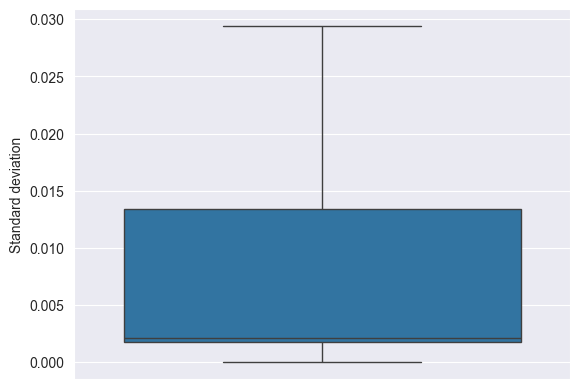

In [18]:
fig, ax = plt.subplots()
sns.boxplot(y=std_y_finals)
ax.set(ylabel='Standard deviation')
#fig.savefig('graphs/DEM_std_Newton.pdf')

In [19]:
max(std_y_finals), min(std_y_finals)

(0.029395698, 0.0)

In [20]:
y_final = np.mean(y_finals, axis=0)

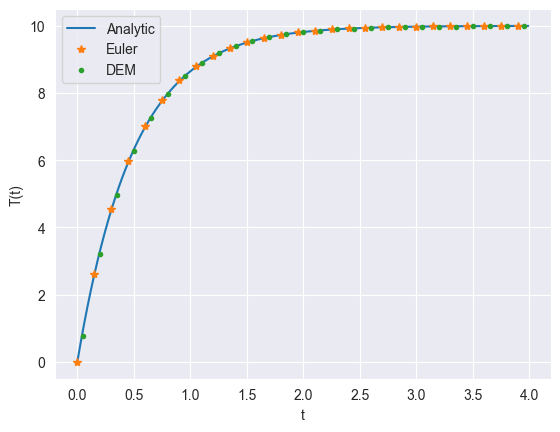

In [21]:
# Plot the solutions
fig, ax = plt.subplots()
plt.plot(x_test.numpy(), y_test_true.numpy(), label='Analytic')
plt.plot(x_test.numpy()[::15], y_euler.numpy()[::15], '*', label="Euler")
plt.plot(x_test.numpy()[5::15], y_final[5::15], '.', label='DEM')
#plt.title("Comparison of solutions of Netwon's Law of Cooling")
plt.xlabel('t')
plt.ylabel('T(t)')
plt.legend()
plt.grid(True)
plt.show()
#fig.savefig('graphs/DEM_solutions_Newton.pdf')

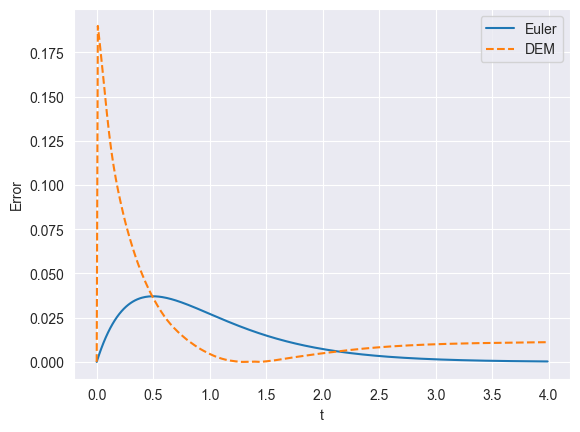

In [22]:
# Plot the error
fig, ax = plt.subplots()
plt.plot(x_test.numpy(), abs(y_test_true-y_euler) , label='Euler')
plt.plot(x_test.numpy(), abs(y_test_true-y_final), label="DEM", linestyle='--')
#plt.title("Comparison of errors of solutions of Netwon's Law of Cooling")
plt.xlabel('t')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.show()
#fig.savefig('graphs/DEM_errors_Newton.pdf')

In [23]:
# Sum of errors
print("Sum of errors for Euler comparing to analytic solution:", round(mae(y_test_true, y_euler),3))
print("Sum of errors for DEM comparing to analytic solution:", round(mae(y_test_true, y_final),3))

Sum of errors for Euler comparing to analytic solution: 0.013
Sum of errors for DEM comparing to analytic solution: 0.018


In [44]:
# comparison of the errors for different h - here without averaging the results

h_list = [0.001, 0.01, 0.1, 1, 2, 3]
errors_euler = []
errors_DEM = []
times_euler = []
times_DEM = []
for h in h_list:
    x_test = torch.arange(0, 4, h)  # Range [0, 4] with h step
    y_test_true = A+(T0-A)*torch.exp(-k*x_test) # True solution of the ODE
    
    # Compute the Euler's method solution
    start_time_euler = time.time()  
    y_euler = euler_solution(x_test)
    end_time_euler = time.time()
    total_time_euler = end_time_euler - start_time_euler
    times_euler.append(total_time_euler)
    
    x_test_for_NN = []
    for i in range(len(x_test)-1):
        x_test_for_NN.append((x_test[i], x_test[i+1], y_test_true[i]))  # x_i, x_j, y_i
        
    x_test_for_NN = torch.tensor([(x_i, x_j, y_i) for x_i, x_j, y_i in x_test_for_NN], dtype=torch.float32)
    
    # Predict the truncation error using the neural network
    start_time_DEM = time.time()
    y_pred = nn_model(x_test_for_NN)
    end_time_DEM = time.time()
    total_time_DEM = end_time_DEM - start_time_DEM 
    times_DEM.append(total_time_DEM + total_time_euler) # we add it because DEM uses the euler in final output
    
    y_pred = y_pred.detach().numpy().flatten()
    
    y_pred = np.insert(y_pred,0,0)
    
    # Compute the final solution by adding Euler's method output and the predicted truncation error
    y_final = y_euler + h*y_pred
    
    errors_euler.append(mae(y_test_true, y_euler))
    errors_DEM.append(mae(y_test_true, y_final))

In [45]:
print(f"Errors from Euler: {['%.3f' % elem for elem in errors_euler]}")
print(f"Computation time of Euler approximation: {['%.4f' % elem for elem in times_euler]}")

Errors from Euler: ['0.001', '0.013', '0.129', '7.799', '15.092', '25.012']
Computation time of Euler approximation: ['0.0535', '0.0065', '0.0005', '0.0000', '0.0000', '0.0000']


In [46]:
print(f"Errors from DEM: {['%.3f' % elem for elem in errors_DEM]}")
print(f"Computation time of DEM approximation: {['%.4f' % elem for elem in times_DEM]}")

Errors from DEM: ['0.002', '0.019', '0.185', '5.276', '6.918', '17.850']
Computation time of DEM approximation: ['0.0614', '0.0068', '0.0006', '0.0001', '0.0001', '0.0001']
